In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [4]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


In [5]:
class Discriminator(nn.Module):

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [7]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


In [12]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 0.8966179513931278, discriminator loss: 0.5141862879097465


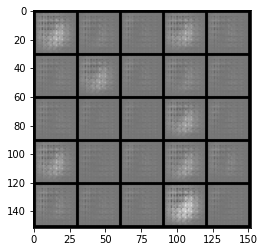

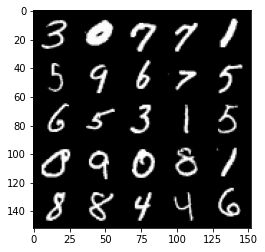

Step 1000: Generator loss: 1.4399631409645075, discriminator loss: 0.38324189750850196


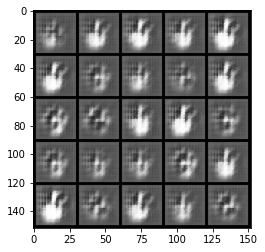

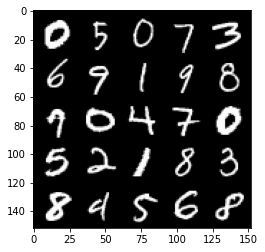

Step 1500: Generator loss: 1.2739516939818862, discriminator loss: 0.47233317264914504


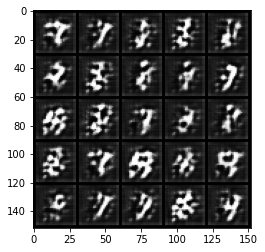

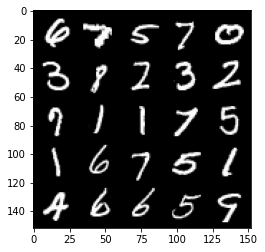

Step 2000: Generator loss: 1.0260509889125824, discriminator loss: 0.5457854124307626


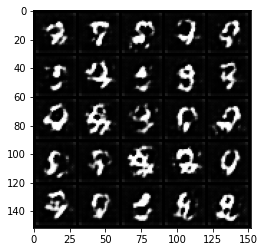

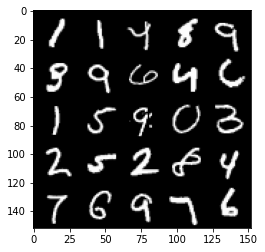

Step 2500: Generator loss: 0.8820629119276996, discriminator loss: 0.599301081657409


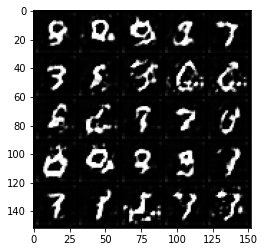

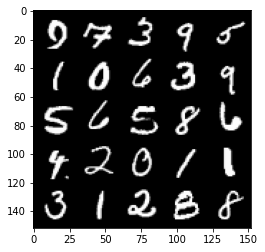

Step 3000: Generator loss: 0.8395539901256558, discriminator loss: 0.6227454572916025


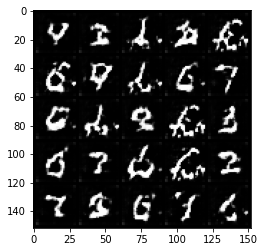

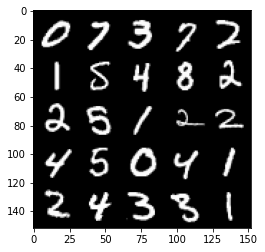

Step 3500: Generator loss: 0.8425220023989674, discriminator loss: 0.6295883636474607


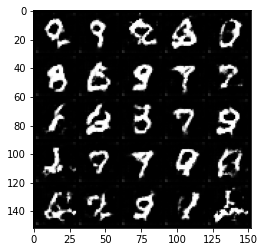

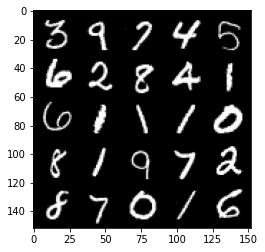

Step 4000: Generator loss: 0.8146283799409875, discriminator loss: 0.6387687176465991


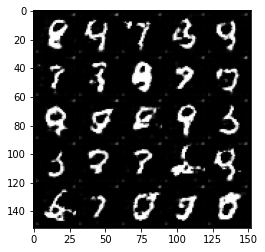

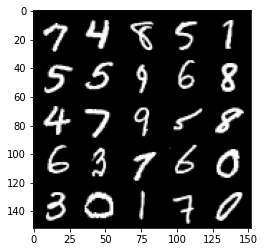

Step 4500: Generator loss: 0.8112997189760207, discriminator loss: 0.6464359353780741


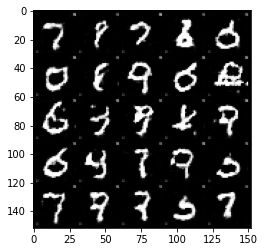

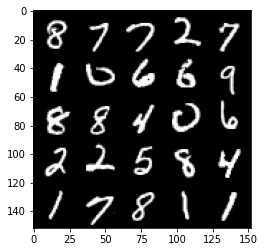

Step 5000: Generator loss: 0.8003556315302844, discriminator loss: 0.6548271254301079


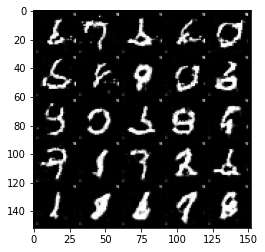

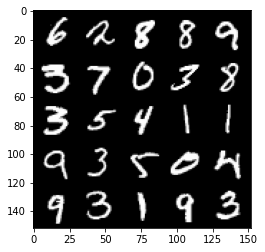

Step 5500: Generator loss: 0.7937900977134699, discriminator loss: 0.6546419478654854


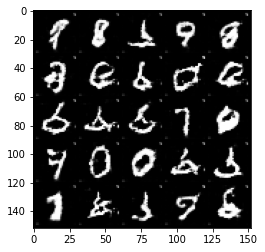

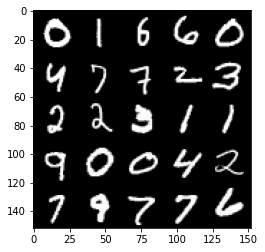

Step 6000: Generator loss: 0.7815066968798638, discriminator loss: 0.6592826508283618


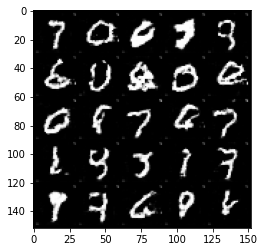

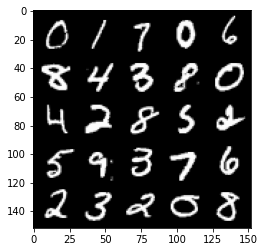

Step 6500: Generator loss: 0.768967861831188, discriminator loss: 0.6653648909330366


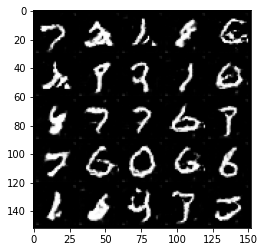

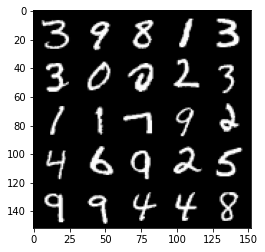

Step 7000: Generator loss: 0.7642078847885124, discriminator loss: 0.6701518270969384


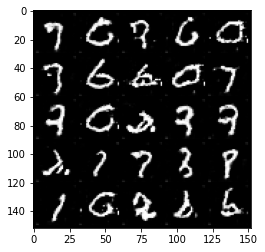

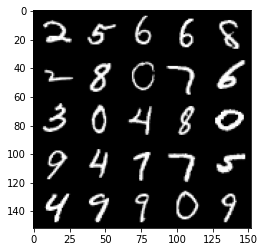

Step 7500: Generator loss: 0.7611935130357746, discriminator loss: 0.6744017012119293


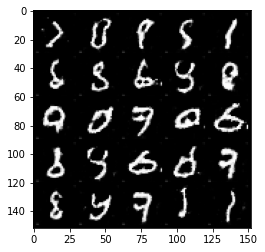

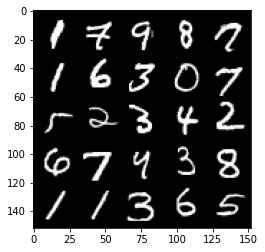

Step 8000: Generator loss: 0.755817993760108, discriminator loss: 0.6783021239042283


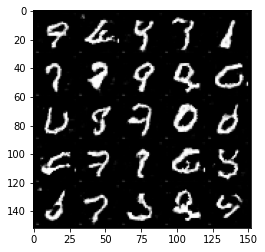

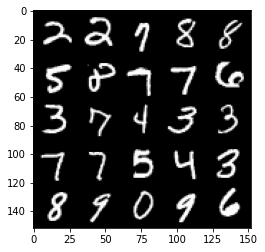

Step 8500: Generator loss: 0.7513298139572137, discriminator loss: 0.6798427790403369


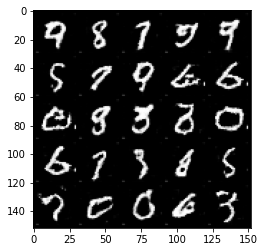

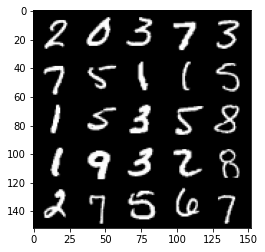

Step 9000: Generator loss: 0.7467649835348127, discriminator loss: 0.6826112976074221


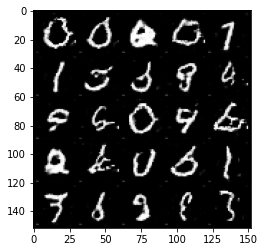

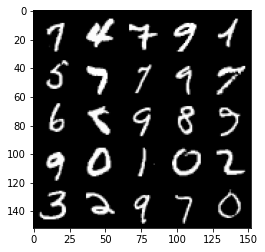

Step 9500: Generator loss: 0.7434805268049237, discriminator loss: 0.687525014996529


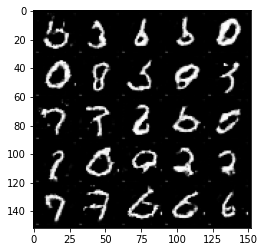

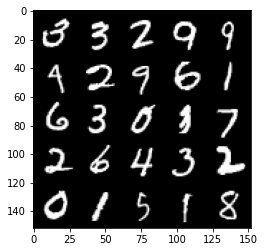

Step 10000: Generator loss: 0.7334935826063161, discriminator loss: 0.6876055107116698


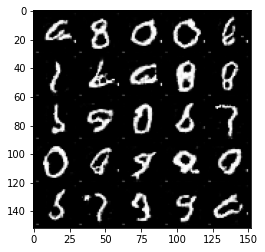

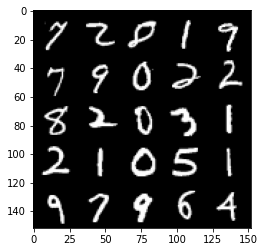

Step 10500: Generator loss: 0.7338251402378079, discriminator loss: 0.6893285731077193


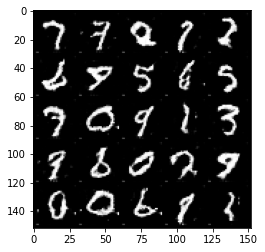

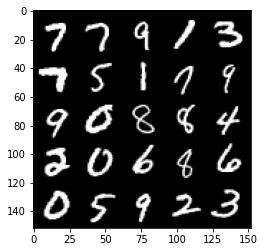

Step 11000: Generator loss: 0.7285714388489721, discriminator loss: 0.6912264572381974


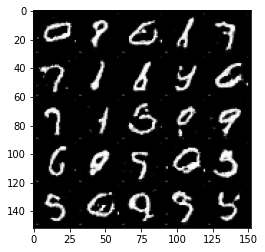

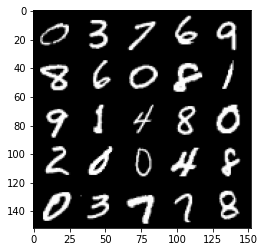

Step 11500: Generator loss: 0.7237757073640826, discriminator loss: 0.6914920183420181


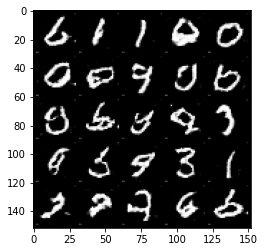

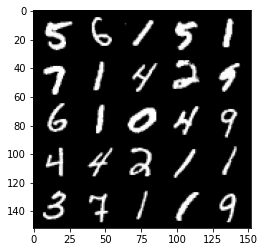

Step 12000: Generator loss: 0.7226188721060748, discriminator loss: 0.691776988267899


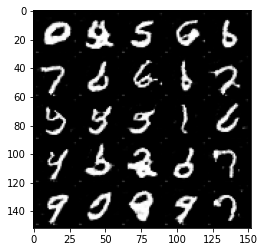

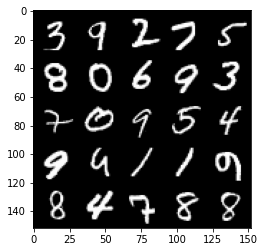

Step 12500: Generator loss: 0.7176227680444717, discriminator loss: 0.6935459672212604


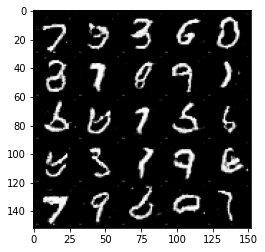

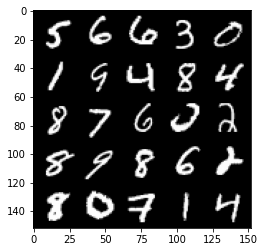

Step 13000: Generator loss: 0.7190249616503721, discriminator loss: 0.6932953249216085


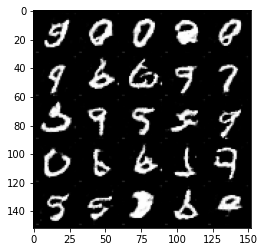

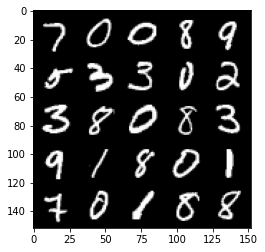

Step 13500: Generator loss: 0.7176934036612505, discriminator loss: 0.6937874083518982


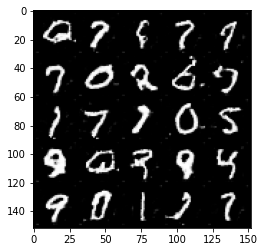

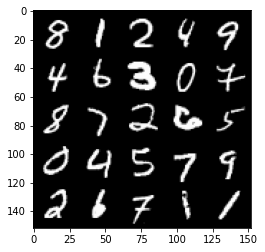

Step 14000: Generator loss: 0.7178633503913882, discriminator loss: 0.6940602617263789


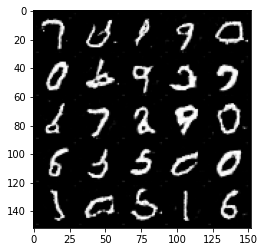

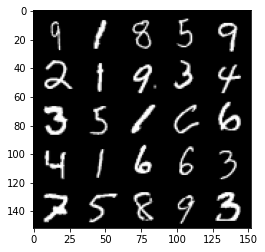

Step 14500: Generator loss: 0.7126299495697018, discriminator loss: 0.6976943752765657


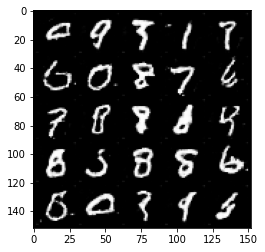

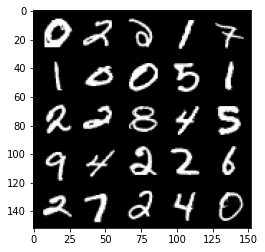

Step 15000: Generator loss: 0.7080184255838397, discriminator loss: 0.6960353316068646


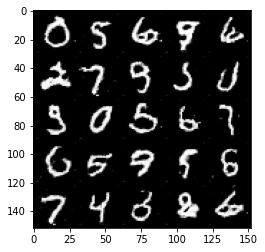

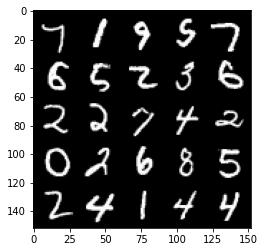

Step 15500: Generator loss: 0.7044919291734691, discriminator loss: 0.6986742911338805


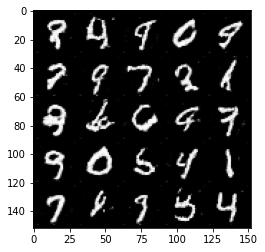

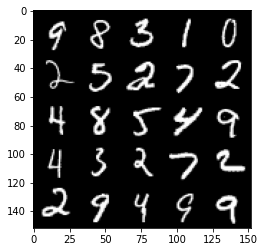

Step 16000: Generator loss: 0.7094950018525122, discriminator loss: 0.6949648144245144


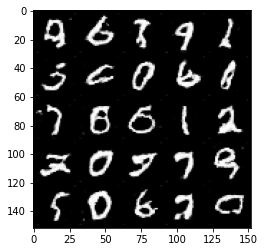

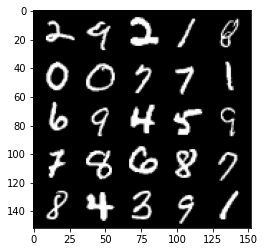

Step 16500: Generator loss: 0.7079959747791293, discriminator loss: 0.6973972414731985


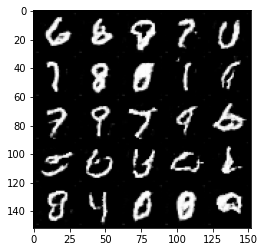

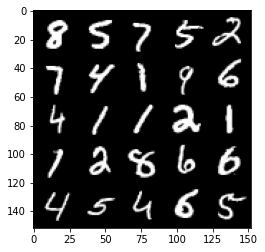

Step 17000: Generator loss: 0.7037112253904341, discriminator loss: 0.6977285227775569


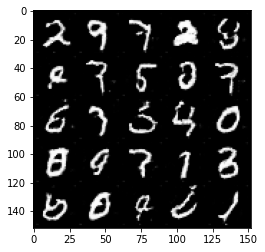

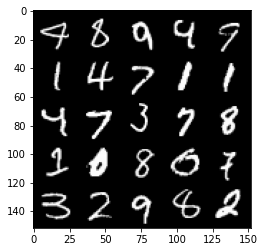

Step 17500: Generator loss: 0.7052482889294632, discriminator loss: 0.6965492838621143


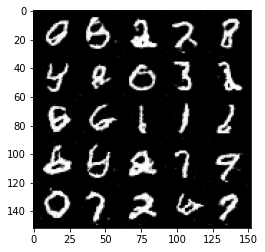

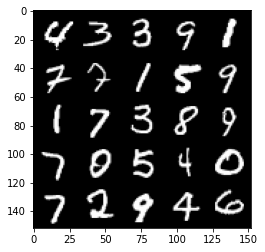

Step 18000: Generator loss: 0.7090005702376356, discriminator loss: 0.6952667659521105


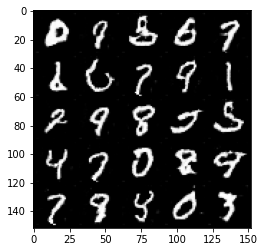

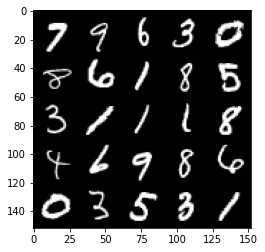

Step 18500: Generator loss: 0.7075922313928601, discriminator loss: 0.6952684185504906


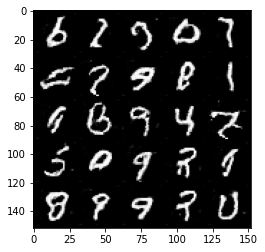

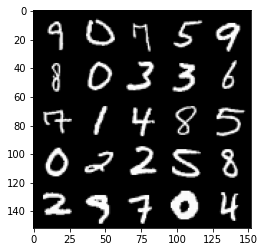

Step 19000: Generator loss: 0.7060860955715177, discriminator loss: 0.695610317349434


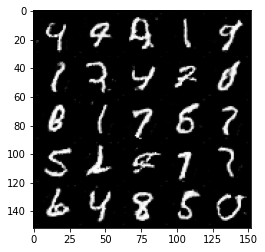

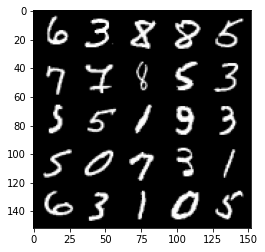

Step 19500: Generator loss: 0.7056248986124986, discriminator loss: 0.6957018456459042


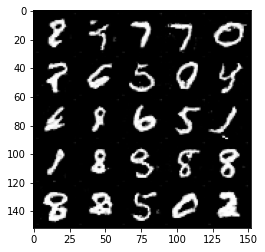

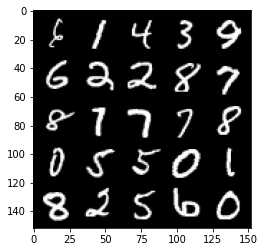

Step 20000: Generator loss: 0.7052838456034661, discriminator loss: 0.6956043330430983


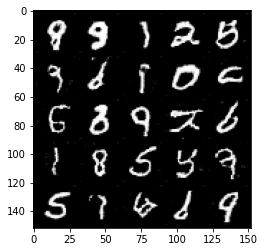

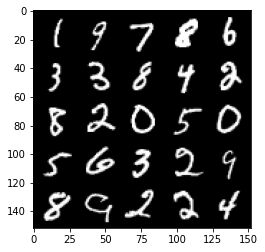

Step 20500: Generator loss: 0.7034157145023341, discriminator loss: 0.6952921252250674


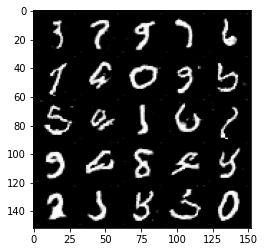

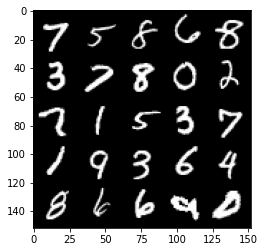

Step 21000: Generator loss: 0.7044811103343962, discriminator loss: 0.6948850789070136


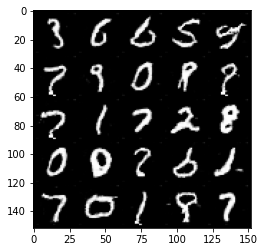

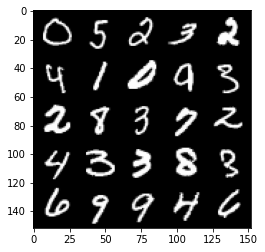

Step 21500: Generator loss: 0.7016708390116689, discriminator loss: 0.6955944293737412


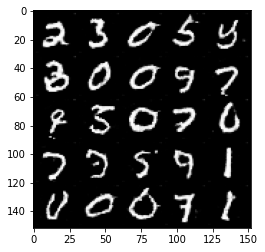

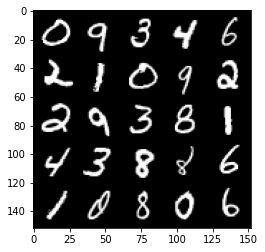

Step 22000: Generator loss: 0.7025675590038302, discriminator loss: 0.6960803723335265


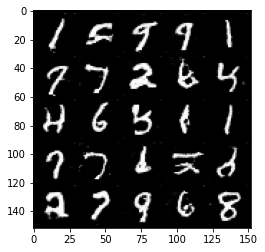

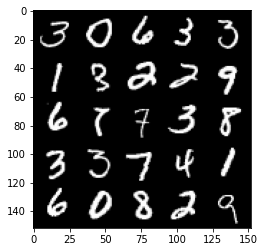

Step 22500: Generator loss: 0.7015035295486444, discriminator loss: 0.6955487457513814


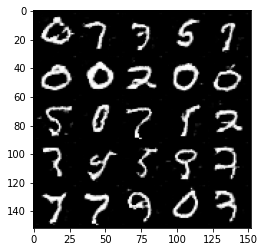

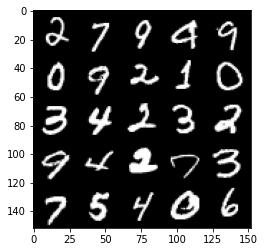

Step 23000: Generator loss: 0.7010407433509834, discriminator loss: 0.6953221410512924


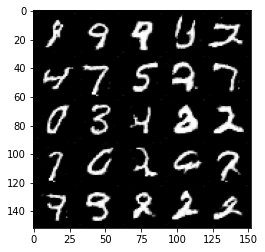

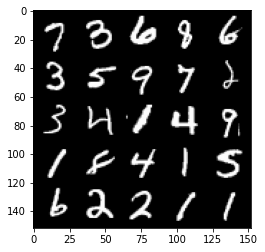

In [10]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
